# Imports and initialization

In [1]:
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import deque

from skimage.metrics import structural_similarity
sys.path.insert(0, os.path.abspath(".."))

In [2]:
from application_flask.model_inference import Embedding_generator
from application_flask.search import HNSW_search_tool
from application_flask.image_processing import Image_processer

In [3]:
EMBEDDING_DATA_PATH = Path('../data/embeddings')
EXAMPLE_FOLDER_PATH = Path('../examples')

model_interface = Embedding_generator()
hnsw_search = HNSW_search_tool(768, 'cosine', str(EMBEDDING_DATA_PATH / 'hnsw_index_cos.bin'), 50, str(EMBEDDING_DATA_PATH / 'image_emb_metadata.json'))
image_processer = Image_processer(None)

Model has loaded
Search Engine has loaded
Image Processer has loaded


In [9]:
video_path = EXAMPLE_FOLDER_PATH / 'example_video.mp4'

cap = cv2.VideoCapture(video_path)

sliding_window = deque(maxlen=20)

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        frame_, contours = image_processer.find_big_contours(frame)
        
        # Рисуем кадры 
        cv2.imshow("frame", frame_)            
        cv2.waitKey(20)

        # Проверку на стабильность вынес отдельно
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame_gray = cv2.resize(frame_gray, (0, 0), fx=0.5, fy=0.5)
        sliding_window.append(frame_gray)
        if len(sliding_window) < 20:
            continue 
        accumulated = np.mean(np.array(sliding_window), axis=0).astype(np.uint8)
        score, diff = structural_similarity(frame_gray, accumulated, full=True)
        if score >= 0.85:
            try:
                warped_images = [image_processer.crop_warp_image_from_contour(frame, contour) for contour in contours]
                embeddings = model_interface.generate_image_embedding(warped_images)
                results = [hnsw_search.search_in_hnsw(embedding, k=200)[0] for embedding in embeddings]
                print(results)
                break
            except:
                pass
    else:
        break
    
cap.release()
cv2.destroyAllWindows()

[{'card_number': '273', 'card_set': 'khm', 'card_name': 'Volatile Fjord', 'card_language': 'ru', 'card_side': None}]


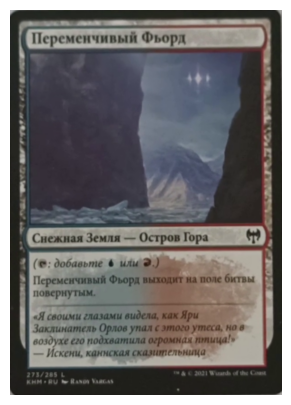

In [13]:
fig, ax = plt.subplots(1, len(contours), figsize=(15, 5))

if len(contours) == 1:
    ax = [ax]

for i, warped in enumerate(warped_images):
    ax[i].imshow(warped)
    ax[i].axis('off')